In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
np.set_printoptions(precision=3)
from qiskit.providers.aer.noise import NoiseModel

IBMQ.load_account()
from scipy import linalg

# IBMQ.save_account('fb30d6ed3e7c1557fe60e36b2c8818ea67ec079e4bc1a9d0ab89b0be7f42fdaf7a7934f3354e4bd67069ea5b783bdb6fa2c7826015aead948821b4ace90f4cf4

ibmqfactory.load_account:WARNING:2020-08-09 16:21:38,545: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def textResults(results,collisions):
    for key in results:
        if(results[key]>collisions):
          text= str(key)+ '->'+  str(results[key])
    return text

def setProvider(hub,group,project):
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)
    return provider

def leastBusy(minQubits,provider):
    large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and not x.configuration().simulator)
    leastBusybackend = least_busy(large_enough_devices)

    return leastBusybackend

def getJobCounts(result,backend):
    jobID = result.job_id()
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()

    return resultCount
    
def listBackends(provider):
    for backend in provider.backends():
        print( backend.name())

def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()

    return resultCount

In [15]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
  

In [185]:
def toket(N,st):
    mat = eye(N)
    state = zeros(N)
    state = mat[:,st]
    return state

def outercalc(N,st1,st2):
    a=toket(N,st1)
    b=toket(N, st2)
    return outer(a,b)

def matrix(marked,marked2,gamma,N,adjunct):
    c = np.zeros((2**N,2**N))
    c[marked][marked] = -1.0*(gamma)
    #c[marked2][marked2] = -1.0*(2*gamma/3)
    #c = c*gamma
    if adjunct==True :
        mat = linalg.expm(-1j*c)
    else:
        mat = linalg.expm(1j*c)

    # matprint(mat)

#     print()
#     print()
#   #  matprint(mat)
#     print()
#     print()
#     print(mat.diagonal())
#     print()
#     print()
    
    return mat

def oracle(N,mat):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg)
    qc.diagonal(mat.tolist(),qreg)
    return qc

In [186]:
N=3
marked = 6
marked2 = 1
gamma = np.pi

mat = matrix(marked,marked2,gamma,N,True).diagonal()
qcaux = oracle(N,mat)
#qcaux.draw(output='mpl')

print()
mat2 = matrix(marked,marked2,gamma,N,False).diagonal()
qcaux2 = oracle(N,mat2)
#qcaux2.draw(output='mpl')

#print(mat)

1+0j  0+0j  0+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  1+0j  0+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  1+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  1+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  1+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  1+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  0+0j  -1+1.22465e-16j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  0+0j             0+0j  1+0j  

1+0j  0+0j  0+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  1+0j  0+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  1+0j  0+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  1+0j  0+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  1+0j  0+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  1+0j             0+0j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  0+0j  -1-1.22465e-16j  0+0j  
0+0j  0+0j  0+0j  0+0j  0+0j  0+0j             0+0j  1+0j  


In [184]:
qreg = QuantumRegister(N)
creg = ClassicalRegister(N)
qc = QuantumCircuit(qreg,creg)
N2 = 3
# angle = -0.5417
angle = 2*((np.pi)/N)
steps =8

qc.h(qreg)
for t in range(steps):
    qc.append(qcaux,range(N))
    qc.rx(angle,qreg)
    qc.append(qcaux2,range(N))
    qc.rx(angle,qreg)
    qc.barrier()
    
qc.measure(qreg,creg)

qc = transpile(qc,optimization_level=0)

#qc.draw(output='mpl')
#qc.draw()

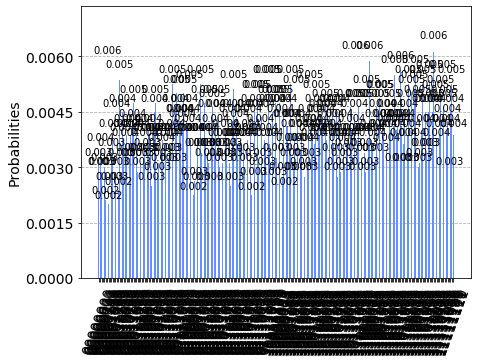

In [180]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend=backend,shots=8000)
result_sim = job_sim.result()
result_counts = result_sim.get_counts(qc)
plot_histogram(result_counts)

In [272]:
provider = setProvider('ibm-q-minho','academicprojects','quantalab')

In [273]:
torontoBackend = provider.get_backend('ibmq_toronto')
melBackend = provider.get_backend('ibmq_16_melbourne')
cambBackend = provider.get_backend('ibmq_cambridge')
rochBackend = provider.get_backend('ibmq_rochester')
bogBackend = provider.get_backend('ibmq_bogota')
joanBackend = provider.get_backend('ibmq_johannesburg')

In [274]:
deviceBackend = joanBackend
basisGatesD = deviceBackend.configuration().basis_gates

In [275]:
noiseModel = NoiseModel.from_backend(deviceBackend)
basisGates = noiseModel.basis_gates

In [276]:
couplingMap = deviceBackend.configuration().coupling_map

In [277]:
simulator = Aer.get_backend('qasm_simulator')

In [278]:
resultNoiseB = execute(qc,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoiseB = resultNoiseB.get_counts(qc)

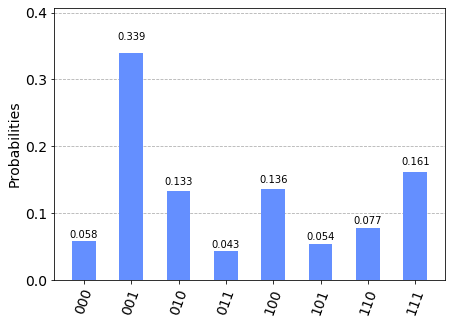

In [279]:
plot_histogram(countsNoiseB)